In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [2]:
class Insurance:
    def __init__(self, file_path: str):
        self.df = pd.read_csv(file_path)
        self.training_results: pd.DataFrame
        self.models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"),
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
            "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
            "SVM": SVC(kernel='linear', random_state=42, class_weight="balanced"),
            "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
            "KNN": KNeighborsClassifier(n_neighbors=5),
            "Naive Bayes": GaussianNB()
        }
        self.categorical_cols = ['Insurance Company', 'CPT4 - Procedure', 'Diag 1', 'Diag 2', 'Modality', 'Place Of Serv']
        self.model_path = "trained_models/"  # Directory to save models

    def clean_data(self, file_path: str = None, training: bool = False):
        df = pd.read_csv(file_path) if file_path else self.df

        if 'Denied' not in df.columns:
            df['Denied'] = 'Void'
        
        df = df.drop(columns=['Mod 1', 'Mod 2'])
        df['Diag 2'] = df['Diag 2'].fillna('None')
        df['Modality'] = df['Modality'].fillna('Unknown')
        df['Denied'] = df['Denied'].apply(lambda x: 'Denied' if pd.notna(x) else x)
        df['Denied'] = df['Denied'].fillna('Accepted')

        # Label encode target variable
        df['Denied'] = df['Denied'].map({'Denied': 0, 'Accepted': 1})

        # One-hot encode categorical variables
        df_encoded = pd.get_dummies(df, columns=self.categorical_cols, drop_first=True)

        if training:
            self.feature_names = df_encoded.columns.tolist()  # Store feature names

        else:
            missing_cols = [col for col in self.feature_names if col not in df_encoded.columns]

            if missing_cols:
                missing_df = pd.DataFrame(0, index=df_encoded.index, columns=missing_cols)
                df_encoded = pd.concat([df_encoded, missing_df], axis=1)

            df_encoded = df_encoded[self.feature_names]

        # Split X and y
        X = df_encoded.drop(columns=['Denied'])
        y = df_encoded['Denied']
        X = X.astype(float)

        # Apply SMOTE only during training
        if training:
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)
            return train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

        return X
    
    def eda(self, column: str):
        """Performs Exploratory Data Analysis (EDA) on the specified column."""
        if column not in self.df.columns:
            print(f"Column '{column}' not found in the dataset.")
            return
        
        print(f"Performing EDA on '{column}'...\n")
        
        # Summary statistics
        print("Summary Statistics:")
        print(self.df[column].describe())
        print("\n")

        y_size = round(len(self.df[column].unique()) / 6)

        # Check if column is categorical or numerical
        if self.df[column].dtype == 'object':
            print("Value Counts:")
            print(self.df[column].value_counts())
            plt.figure(figsize=(10, y_size))
            sns.countplot(y=self.df[column], order=self.df[column].value_counts().index, hue=self.df[column], palette="viridis", legend=False)
            plt.title(f"Distribution of {column}")
            plt.xlabel("Count")
            plt.ylabel(column)
            plt.show()
        else:
            plt.figure(figsize=(10, y_size))
            sns.histplot(self.df[column], bins=30, kde=True, color="blue")
            plt.title(f"Distribution of {column}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.show()

    
    def train(self):
        results = {}
        X_train, X_test, y_train, y_test = self.clean_data(training=True)

        # Ensure model directory exists
        os.makedirs(self.model_path, exist_ok=True)

        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)  # Train
            y_pred = model.predict(X_test)  # Predict

            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_proba = model.decision_function(X_test)
            else:
                y_proba = None

            results[name] = {
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(y_test, y_pred),
                "Recall": recall_score(y_test, y_pred),
                "F1 Score": f1_score(y_test, y_pred),
                "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A",
                "Confusion Matrix": confusion_matrix(y_test, y_pred)
            }

            # Save trained model
            model_filename = f"{self.model_path}{name.replace(' ', '_')}.pkl"
            joblib.dump(model, model_filename)

        self.training_results = pd.DataFrame(results).T
        print("All models trained and saved successfully.")

    def generate_validation_csv(self, num_rows: int, file_path: str):
        if num_rows > len(self.df):
            raise ValueError("num_rows cannot be greater than the number of rows in the DataFrame")
    
        df = self.df.sample(n=num_rows, random_state=None).reset_index(drop=True)
        ref = df["Denied"]
        df.drop(columns=["Denied"], inplace=True)
        df.to_csv(file_path, index=False)

        return ref.fillna("Accepted").rename("Original Result")

    def predict(self, model_name: str, file_path: str):
        """Load a trained model and make predictions."""
        model_file = f"{self.model_path}{model_name.replace(' ', '_')}.pkl"
        try:
            model = joblib.load(model_file)
        except FileNotFoundError:
            print(f"Model '{model_name}' not found. Please train the model first.")
            return
        
        X = self.clean_data(file_path=file_path)
        y_pred = model.predict(X)
        return np.where(y_pred == 1, "Accepted", "Denied")

In [3]:
omega = Insurance(file_path="./Omega_healthcare.csv")

## EDA

Performing EDA on 'Place Of Serv'...

Summary Statistics:
count       2000
unique         5
top       Office
freq        1842
Name: Place Of Serv, dtype: object


Value Counts:
Place Of Serv
Office                                              1842
Outpatient Hospital                                   83
Inpatient Hospital                                    51
Ambulatory Surgical Center                            18
Telehealth Provided Other than in Patient's Home       6
Name: count, dtype: int64


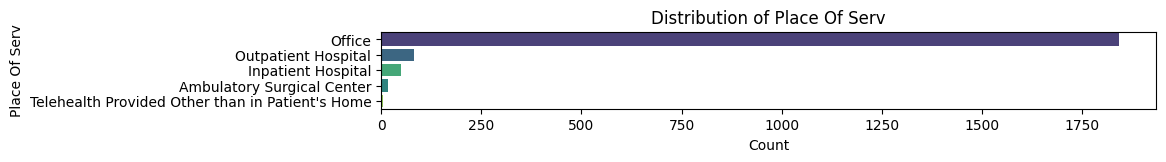

In [4]:
# parameters: ['Insurance Company', 'CPT4 - Procedure', 'Diag 1', 'Diag 2', 'Modality', 'Place Of Serv']
omega.eda("Place Of Serv")

In [5]:
omega.train()

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training Neural Network...
Training KNN...
Training Naive Bayes...
All models trained and saved successfully.


In [6]:
omega.training_results

,Accuracy,Precision,Recall,F1 Score,ROC-AUC,Confusion Matrix
Logistic Regression,0.855093,0.884735,0.816092,0.849028,0.921125,"[[312, 37], [64, 284]]"
Random Forest,0.962697,0.949721,0.977011,0.963173,0.99191,"[[331, 18], [8, 340]]"
Gradient Boosting,0.901004,0.882192,0.925287,0.903226,0.948511,"[[306, 43], [26, 322]]"
SVM,0.870875,0.93,0.801724,0.861111,0.919816,"[[328, 21], [69, 279]]"
Neural Network,0.965567,0.987952,0.942529,0.964706,0.995525,"[[345, 4], [20, 328]]"
KNN,0.71736,0.957576,0.454023,0.615984,0.852711,"[[342, 7], [190, 158]]"
Naive Bayes,0.734577,1.0,0.468391,0.637965,0.734195,"[[349, 0], [185, 163]]"


In [7]:
validation_path = './valid.csv'
reference_result = omega.generate_validation_csv(30, validation_path)

In [8]:
predictions = omega.predict(model_name='Neural Network', file_path=validation_path)

## Actual Result

In [9]:
print(reference_result.values)

['Accepted' 'Denied' 'Accepted' 'Accepted' 'Accepted' 'Accepted'
 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Denied'
 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted'
 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Denied'
 'Accepted' 'Denied' 'Accepted' 'Accepted' 'Denied' 'Accepted']


## Predictions

In [10]:
print(predictions)

['Accepted' 'Denied' 'Accepted' 'Accepted' 'Accepted' 'Accepted'
 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Denied'
 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted'
 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Accepted' 'Denied'
 'Accepted' 'Denied' 'Accepted' 'Accepted' 'Denied' 'Accepted']


# Insurance Claim Denial Prediction - Summary

This project builds a machine learning pipeline to predict insurance claim denials, using SMOTE to address class imbalance and evaluating seven classification models.

## Key Results

Out of the models tested:

- **Random Forest** and **Neural Network** performed best, achieving over **96% accuracy**, **high precision**, and **strong recall**, with ROC-AUC scores above **0.99**.
- **Gradient Boosting** and **SVM** also delivered solid performance, balancing precision and recall well.
- **Logistic Regression** showed reliable, balanced performance with an ROC-AUC of **0.92**.
- **KNN** and **Naive Bayes** had high precision but **low recall**, indicating they struggle with correctly identifying positive (Accepted) cases.

## Conclusion

The Random Forest and Neural Network models are the most effective for predicting claim denials in this dataset and are recommended for deployment in real-time scenarios.